# Lab 3
Lucas Street, 1874989

In [2]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas pyuvdata
# Also install https://github.com/HERA-Team/hera_cal

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from hera_cal.io import HERAData

In [3]:
filename = '../Lab 5/zen.2458108.57290.HH.uvh5'
hd = HERAData(filename)

def get_spectrogram(hd, selected_times, freq_channels, *args, filter_dupes=False, **kwargs):
    hd.read(times=selected_times, freq_chans=freq_channels)
    if filter_dupes:
        pairs = np.array(hd.get_antpairs())
        no_dupe_pairs = pairs[pairs[:, 0] != pairs[:, 1]]
        hd.select(bls=list(map(tuple, no_dupe_pairs)))
    data = hd.get_data(*args, **kwargs)
    times = hd.get_times(*args, **kwargs)
    times -= times[0]
    freqs_mhz = hd.freq_array.flatten() / 1e6
    return pd.DataFrame(data, times, freqs_mhz), times, freqs_mhz

def plot_spectrogram(freqs, times, data, colorbar=True):
    # Handle case where we only have one unique time
    single_time = False
    if times[0] == times[-1]:
        single_time = True
        times = [0, 1]
    
    plt.imshow(np.abs(data), origin='bottom', extent=(freqs[0], freqs[-1], times[0], times[-1]), aspect='auto')
    
    if single_time:
        # No need for a time axis if we only have one time
        plt.gca().get_yaxis().set_visible(False)
    
    plt.ylabel('Time (JD)')
    plt.xlabel('Frequency (MHz)')
    if colorbar:
        cbar = plt.colorbar()
        cbar.set_label('Amplitude')
    
def plot_avg_amplitudes(freqs, times, data):
    avg_amplitudes = np.mean(np.abs(data), axis=0)
    plt.plot(freqs, avg_amplitudes)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Amplitude')
    plt.xlim(freqs[0], freqs[-1])
    
def plot_histogram(times, frequency_channels, max_amplitude=0.4, polarization='XX'):
    all_antenna_data, _, _ = get_spectrogram(hd, times, frequency_channels, polarization)
    hist_data = np.abs(np.array(all_antenna_data).flatten())
    hist_data = hist_data[np.abs(hist_data) < max_amplitude]
    # print(len(hist_data))
    plt.title(f"Background distribution for time {times.round(4)}")
    plt.xlabel('Amplitude')
    plt.ylabel('Probability Density')
    plt.hist(hist_data, bins=100, density=True);
    return hist_data

def plot_lognormal_fit(hist_data, max_amplitude=0.4):
    sigma, mean, scale = stats.lognorm.fit(hist_data)
    dist = stats.lognorm(sigma, mean, scale)
    x = np.linspace(0, max_amplitude, 1000)
    y = dist.pdf(x)
    plt.plot(x, y, linewidth=4, alpha=0.8)
    plt.yscale('log')
    plt.xlim(0, max_amplitude)
    plt.ylim(1e-4)
    plt.legend(['Lognormal fit', 'Background'])
    print(f"Lognormal: mu: {mean}, sigma: {sigma}, s: {scale}")
    return sigma, mean, scale

## Problem 1

Lognormal: mu: -0.0025773701652760756, sigma: 0.8931867040609118, s: 0.02510290734057528


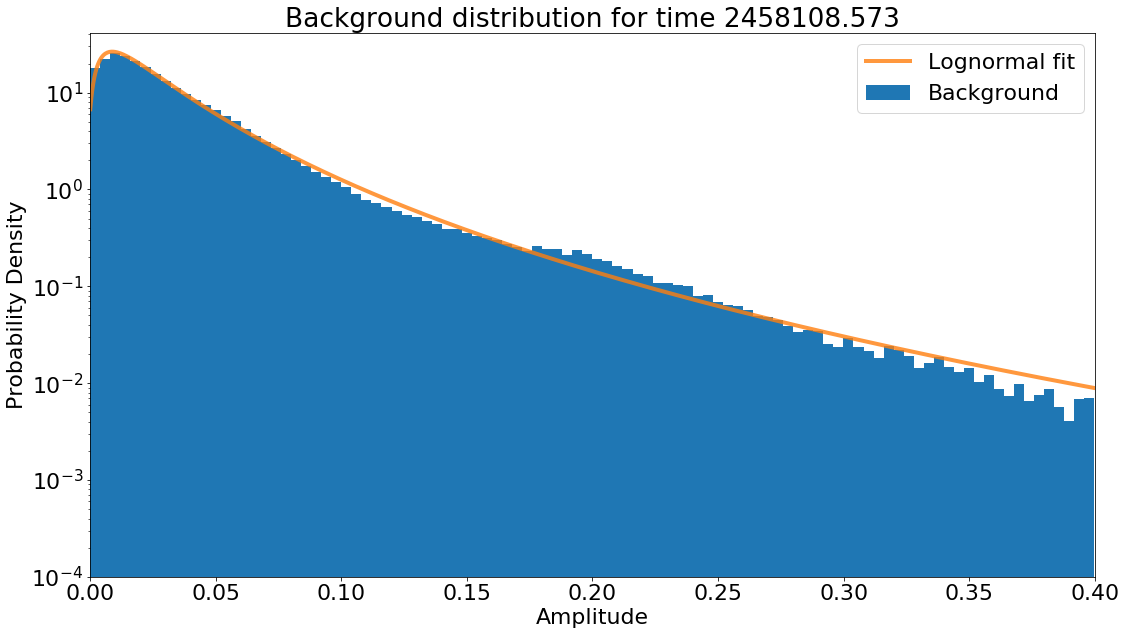

In [4]:
hist_data = plot_histogram(hd.times[0], np.arange(100, 800))
sigma, mean, scale = plot_lognormal_fit(hist_data)

In [5]:
dist = stats.lognorm(sigma, mean, scale)
dist.ppf(stats.norm.cdf(5))

2.181431045119302